# Podcast Listening Time Prediction

This notebook builds a machine learning model to predict podcast listening time based on various podcast attributes.

## 1. Setup and Data Loading

In [54]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from category_encoders import TargetEncoder
import lightgbm as lgb
import optuna
from optuna.samplers import TPESampler
from scipy.stats import uniform, randint

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [74]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [56]:
dup_check_cols = [col for col in train_df.columns if col not in ['id]']]
train_df.drop_duplicates(inplace=True, subset=dup_check_cols)

In [57]:
train_df.shape

(750000, 12)

In [61]:
train_df.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.000000,662907.000000,750000.000000,603970.000000,749999.000000,750000.000000
mean,374999.500000,64.504738,59.859901,52.236449,1.348855,45.437406
std,216506.495284,32.969603,22.873098,28.451241,1.151130,27.138306
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,35.730000,39.410000,28.380000,0.000000,23.178350
50%,374999.500000,63.840000,60.050000,53.580000,1.000000,43.379460
75%,562499.250000,94.070000,79.530000,76.600000,2.000000,64.811580
max,749999.000000,325.240000,119.460000,119.910000,103.910000,119.970000


In [62]:
train_df.describe(include=['object'])

,Podcast_Name,Episode_Title,Genre,Publication_Day,Publication_Time,Episode_Sentiment
count,750000,750000,750000,750000,750000,750000
unique,48,100,10,7,4,3
top,Tech Talks,Episode 71,Sports,Sunday,Night,Neutral
freq,22847,10515,87606,115946,196849,251291


## Dataset Columns Description:

1. **id**: Unique identifier for each podcast episode
2. **Podcast_Name**: Name of the podcast 
3. **Episode_Title**: Title of the specific episode
4. **Episode_Length_minutes**: Duration of episode in minutes
5. **Genre**: Category/genre of the podcast
6. **Host_Popularity_percentage**: Popularity score of the podcast host (0-100)
7. **Publication_Day**: Day of episode publication
8. **Publication_Time**: Time when episode was published
9. **Guest_Popularity_percentage**: Popularity score of episode guest (0-100)
10. **Number_of_Ads**: Count of advertisements in the episode
11. **Episode_Description_Length**: Length of the episode description text

In [63]:
train_df.nunique()

id                             750000
Podcast_Name                       48
Episode_Title                     100
Episode_Length_minutes          12268
Genre                              10
Host_Popularity_percentage       8038
Publication_Day                     7
Publication_Time                    4
Guest_Popularity_percentage     10019
Number_of_Ads                      12
Episode_Sentiment                   3
Listening_Time_minutes          42807
dtype: int64

In [64]:
train_df.isnull().sum()


id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

To handle the skewed distribution, we can try log transformation of the data. Since Number_of_Ads contains zeros, we'll use log1p (log(x+1)) transformation to avoid undefined values.

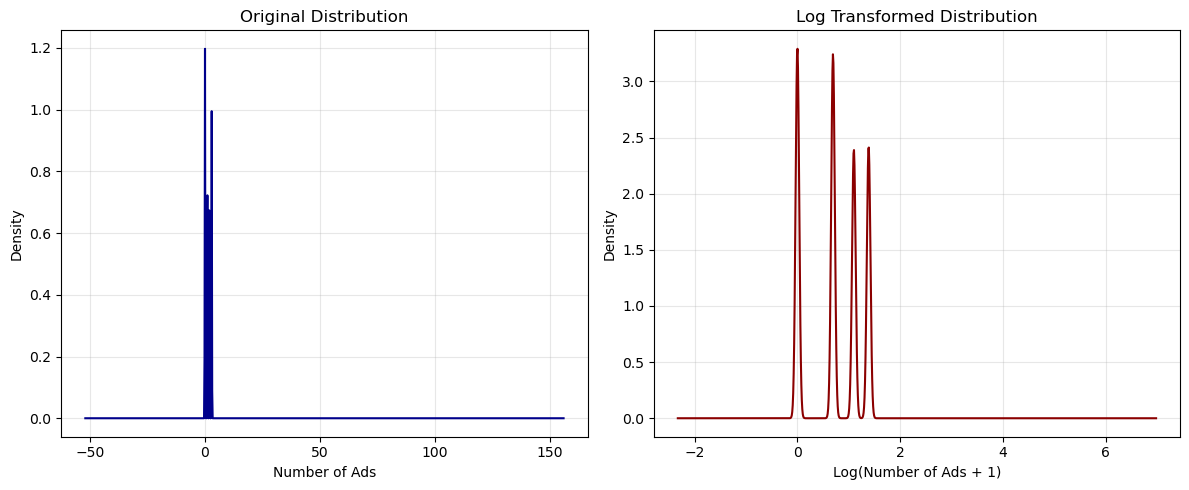

In [65]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
train_df['Number_of_Ads'].plot(kind='kde', color='darkblue')
plt.title('Original Distribution')
plt.xlabel('Number of Ads')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)

plt.subplot(122)
np.log1p(train_df['Number_of_Ads']).plot(kind='kde', color='darkred')
plt.title('Log Transformed Distribution')
plt.xlabel('Log(Number of Ads + 1)')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The log transformation helps to spread out the data more evenly and makes the distribution more symmetric, which can be useful for further analysis or modeling.


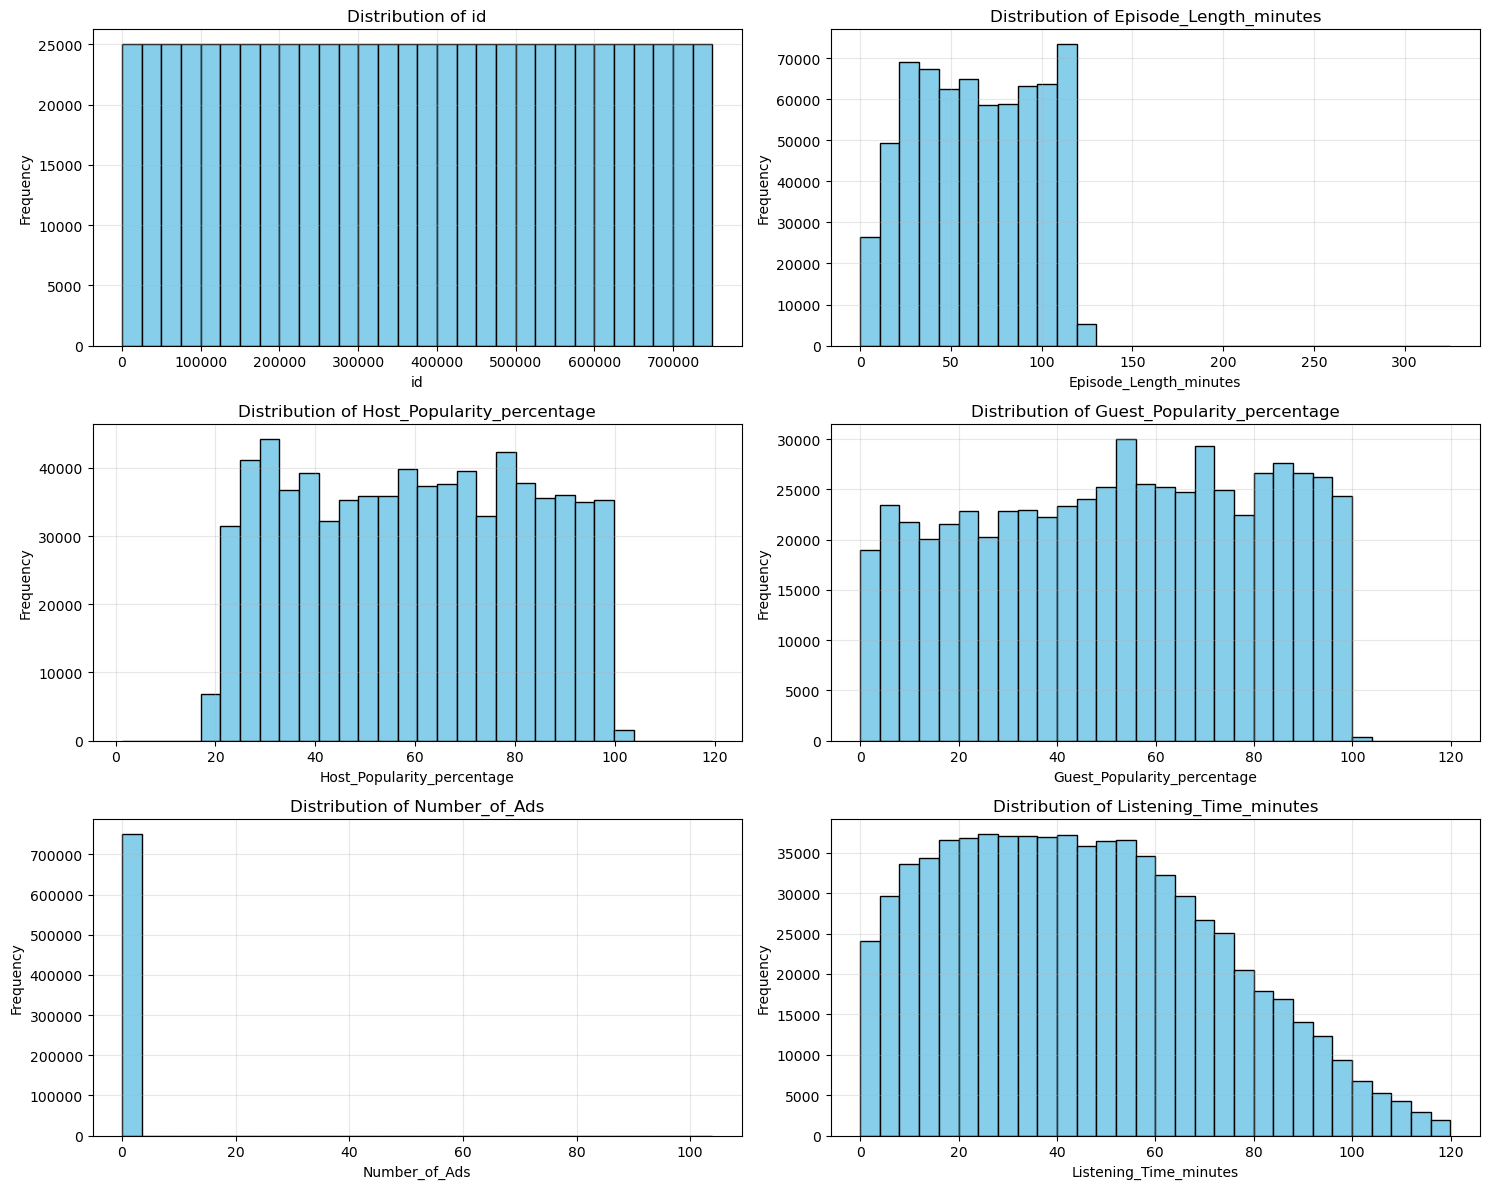

In [66]:
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
n_cols = len(numerical_cols)
n_rows = (n_cols + 1) // 2  # Ceiling division to determine number of rows needed

plt.figure(figsize=(15, 4 * n_rows))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, 2, i)
    plt.hist(train_df[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


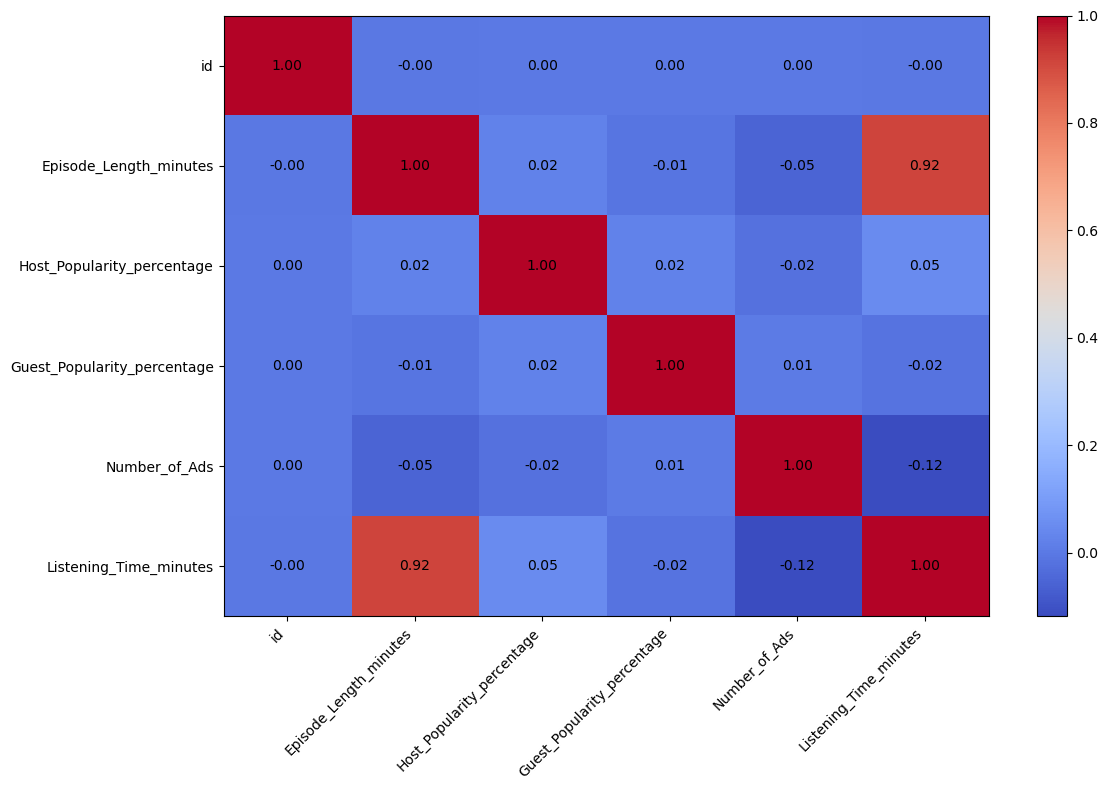

In [67]:
plt.figure(figsize=(12, 8))
numerical_features = train_df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = train_df[numerical_features].corr()

plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(numerical_features)), numerical_features, rotation=45, ha='right')
plt.yticks(range(len(numerical_features)), numerical_features)

for i in range(len(numerical_features)):
    for j in range(len(numerical_features)):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                 ha='center', va='center')

plt.tight_layout()
plt.show()


In [71]:
cat_cols = ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time']
numerical_cols = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage',
                  'Number_of_Ads']


In [79]:
train_df

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Ads_per_minute
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,1,31.41998,NaN
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,-1,88.01241,0.016694
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,-1,44.92531,0.000000
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,1,46.27824,0.029775
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,0,75.61031,0.027147
...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,-1,56.87058,0.000000
749996,749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,0,45.46242,0.026403
749997,749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,-1,15.26000,0.000000
749998,749998,Style Guide,Episode 47,108.98,Lifestyle,45.39,Thursday,Morning,93.27,0.0,-1,100.72939,0.000000


In [78]:
train_df['Ads_per_minute'] = train_df['Number_of_Ads'] / (train_df['Episode_Length_minutes'] + 1e-6)
test_df['Ads_per_minute'] = test_df['Number_of_Ads'] / (test_df['Episode_Length_minutes'] + 1e-6)


In [76]:
# Map Episode_Sentiment to numeric values
sentiment_map = {
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1
}

train_df['Episode_Sentiment'] = train_df['Episode_Sentiment'].map(sentiment_map)
test_df['Episode_Sentiment'] = test_df['Episode_Sentiment'].map(sentiment_map)

In [17]:
# Extract episode numbers from Episode_Title and convert to numeric
train_df['Episode_Title'] = train_df['Episode_Title'].str.extract('(\d+)').astype(float)


<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_10012/1373537498.py:2: SyntaxWarning: invalid escape sequence '\d'
  train_df['Episode_Title'] = train_df['Episode_Title'].str.extract('(\d+)').astype(float)


In [80]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)


In [81]:

from category_encoders import TargetEncoder

# Initialize the target encoder with adjusted parameters
te = TargetEncoder(min_samples_leaf=50, smoothing=5)

y_train = train_df['Listening_Time_minutes']
y_val = val_df['Listening_Time_minutes']

X_train = train_df.drop(columns=['id','Listening_Time_minutes']).copy()
X_val = val_df.drop(columns=['id','Listening_Time_minutes']).copy()

# Fit and transform on training data only
X_train_encoded = X_train.copy()
encoded_cats_train = te.fit_transform(X_train[cat_cols], y_train)

# Replace original categorical columns with encoded ones in training set
for col in cat_cols:
    X_train_encoded[col] = encoded_cats_train[col]

# Transform test set using the fitted encoder (without fitting again)
X_val_encoded = X_val.copy()
encoded_cats_val = te.transform(X_val[cat_cols])

# Replace original categorical columns with encoded ones in test set
for col in cat_cols:
    X_val_encoded[col] = encoded_cats_val[col]

In [82]:
import lightgbm as lgb
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, randint
import numpy as np

In [84]:
# Define parameter distributions for random search
param_distributions = {
    'n_estimators': randint(3000, 8000),
    'learning_rate': uniform(0.01, 0.19),  # 0.01 to 0.2
    'max_depth': randint(3, 11),  # 3 to 10
    'min_split_gain': uniform(0.01, 0.99)  # 0.01 to 1
}

# List to store all models and their validation RMSEs
random_search_results = []

# Run 20 trials of random search
import random

random.seed(42)
n_trials = 20

print("Starting RandomizedSearchCV with single train-validation split:")
for i in range(n_trials):
    # Randomly sample hyperparameters
    params = {
        'n_estimators': random.randint(3000, 8000),
        'learning_rate': random.uniform(0.01, 0.2),
        'max_depth': random.randint(3, 10),
        'min_split_gain': random.uniform(0.01, 1.0),
        'verbosity': -1  # Suppress warnings
    }

    # Train model with these parameters
    model = lgb.LGBMRegressor(**params, random_state=42)
    model.fit(X_train_encoded, y_train)

    # Evaluate on validation set
    val_pred = model.predict(X_val_encoded)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

    # Store results
    random_search_results.append((params, val_rmse, model))
    print(f"Trial {i + 1}/{n_trials} - RMSE: {val_rmse:.4f} - Params: {params}")

# Sort results by validation RMSE
random_search_results.sort(key=lambda x: x[1])

# Get best model and parameters
best_params_random, best_rmse_random, best_model_random = random_search_results[0]

print("\nBest parameters from RandomizedSearch:", best_params_random)
print("Best validation RMSE:", best_rmse_random)

# Evaluate on validation set since we don't have test set yet
val_pred_random = best_model_random.predict(X_val_encoded)
val_rmse_random = np.sqrt(mean_squared_error(y_val, val_pred_random))
print(f"Validation RMSE: {val_rmse_random:.4f}")


Starting RandomizedSearchCV with single train-validation split:
Trial 1/20 - RMSE: 12.9621 - Params: {'n_estimators': 3912, 'learning_rate': 0.014752043492306719, 'max_depth': 7, 'min_split_gain': 0.2524429352654414, 'verbosity': -1}
Trial 2/20 - RMSE: 12.9362 - Params: {'n_estimators': 4143, 'learning_rate': 0.14992953069116235, 'max_depth': 4, 'min_split_gain': 0.5945875873245493, 'verbosity': -1}
Trial 3/20 - RMSE: 12.9696 - Params: {'n_estimators': 3260, 'learning_rate': 0.015661471693233366, 'max_depth': 6, 'min_split_gain': 0.2403342844568322, 'verbosity': -1}
Trial 4/20 - RMSE: 12.9251 - Params: {'n_estimators': 7931, 'learning_rate': 0.015041834239934089, 'max_depth': 6, 'min_split_gain': 0.7188594167931794, 'verbosity': -1}
Trial 5/20 - RMSE: 12.8621 - Params: {'n_estimators': 7464, 'learning_rate': 0.08970876598271516, 'max_depth': 10, 'min_split_gain': 0.5933730270371497, 'verbosity': -1}
Trial 6/20 - RMSE: 12.9129 - Params: {'n_estimators': 3053, 'learning_rate': 0.15417339

In [ ]:
import optuna
from optuna.samplers import TPESampler
import numpy as np
from sklearn.metrics import mean_squared_error
import time


# Create a progress tracking callback
class ProgressCallback:
    def __init__(self, n_trials):
        self.start_time = time.time()
        self.n_trials = n_trials

    def __call__(self, study, trial):
        elapsed_time = time.time() - self.start_time
        completed = trial.number + 1
        print(f"Trial {completed}/{self.n_trials} - RMSE: {trial.value:.4f} - "
              f"Best RMSE: {study.best_value:.4f}")


# Define objective function for Optuna using single train-validation split
def objective(trial):
    # Define the hyperparameters to tune (same ranges as RandomizedSearchCV)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 3000, 8000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.01, 1.0),
        'verbosity': -1  # Suppress warnings
    }

    # Initialize model with the sampled hyperparameters
    model = lgb.LGBMRegressor(**params, random_state=42)

    # Train on the training split
    model.fit(X_train_encoded, y_train)

    # Evaluate on validation split
    val_pred = model.predict(X_val_encoded)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

    return val_rmse


# Create a study object with TPE sampler using Gaussian Process-like modeling
sampler = TPESampler()  # multivariate=True enables Gaussian Process-like behavior
study = optuna.create_study(direction='minimize', sampler=sampler)

# Number of trials (same as RandomizedSearchCV)
n_trials = 20

# Run the optimization with progress callback
print("\nStarting Optuna optimization with Gaussian Process sampling and single train-validation split:")
callback = ProgressCallback(n_trials)
study.optimize(objective, n_trials=n_trials, callbacks=[callback])

# Print the best parameters and score
print("\nBest parameters found by Optuna:", study.best_params)
print("Best validation RMSE:", study.best_value)

# Train a final model with the best parameters
best_params = study.best_params.copy()
best_params['verbosity'] = -1  # Keep warnings suppressed
best_model = lgb.LGBMRegressor(**best_params, random_state=42)
best_model.fit(X_train_encoded, y_train)  # Train on full training set

# Evaluate on val set
val_pred = best_model.predict(X_val_encoded)
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
print(f"Val RMSE: {val_rmse:.4f}")

# Compare with random search results
print("\nComparison:")
print(f"Random Search Test RMSE: {val_rmse_random:.4f}")
print(f"Optuna Test RMSE: {val_rmse:.4f}")
diff = val_rmse_random - val_rmse
percent = (diff / val_rmse_random) * 100
print(f"Difference: {diff:.4f} ({percent:.2f}%)")


[I 2025-04-21 19:43:33,384] A new study created in memory with name: no-name-b6b1a1a1-10c8-47ad-bcf9-c2a1397f93ba



Starting Optuna optimization with Gaussian Process sampling and single train-validation split:


[I 2025-04-21 19:43:46,568] Trial 0 finished with value: 12.962903201316884 and parameters: {'n_estimators': 5716, 'learning_rate': 0.1454345822752586, 'max_depth': 3, 'min_split_gain': 0.9312963779943708}. Best is trial 0 with value: 12.962903201316884.


Trial 1/20 - RMSE: 12.9629 - Best RMSE: 12.9629


[I 2025-04-21 19:43:53,591] Trial 1 finished with value: 12.875115888206262 and parameters: {'n_estimators': 3456, 'learning_rate': 0.09918711611782717, 'max_depth': 10, 'min_split_gain': 0.7968841234370295}. Best is trial 1 with value: 12.875115888206262.


Trial 2/20 - RMSE: 12.8751 - Best RMSE: 12.8751


In [ ]:
study.best_params

In [31]:
final_model = lgb.LGBMRegressor(**study.best_params)

In [51]:
# Extract episode numbers from test data (same preprocessing as training data)
test_df['Episode_Title'] = test_df['Episode_Title'].str.extract('(\d+)').astype(float)

# Prepare feature set for test data (drop ID)
X_test_final = test_df.drop(['id'], axis=1)

# Apply the same target encoder to categorical columns
test_encoded = test_df.copy()
encoded_cats_test = te.transform(test_df[cat_cols])

# Replace original categorical columns with encoded ones in test set
for col in cat_cols:
    test_encoded[col] = encoded_cats_test[col]

# Use the best Optuna model to make predictions
# You can choose either the random search or Optuna model
predictions = final_model.predict(test_encoded.drop(['id'], axis=1))

# Create submission dataframe
submission = pd.DataFrame({
    'id': test_df['id'],
    'Listening_Time_minutes': predictions
})

# Display submission preview
print(f"Submission shape: {submission.shape}")
submission.head()

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_10012/268763013.py:2: SyntaxWarning: invalid escape sequence '\d'
  test_df['Episode_Title'] = test_df['Episode_Title'].str.extract('(\d+)').astype(float)


Submission shape: (250000, 2)


,id,Listening_Time_minutes
0,750000,53.315112
1,750001,18.838699
2,750002,48.727616
3,750003,75.098249
4,750004,47.301179


In [52]:
# Save submission to CSV file
submission.to_csv('submission.csv', index=False)
print("Submission saved to 'submission.csv'")

# Additional verification
print(f"Min predicted value: {submission['Listening_Time_minutes'].min()}")
print(f"Max predicted value: {submission['Listening_Time_minutes'].max()}")
print(f"Mean predicted value: {submission['Listening_Time_minutes'].mean()}")

Submission saved to 'submission.csv'
Min predicted value: -2.41822594117753
Max predicted value: 130.70538215295977
Mean predicted value: 45.46130917081562


In [34]:
preds

array([31.81818882, 33.74489724, 36.73470274, ...,  1.1301816 ,
       83.0642445 , 80.20815781])

In [37]:
test_df['Episode_Title'] = test_df['Episode_Title'].str.extract('(\d+)').astype(float)

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_10012/2640890256.py:1: SyntaxWarning: invalid escape sequence '\d'
  test_df['Episode_Title'] = test_df['Episode_Title'].str.extract('(\d+)').astype(float)


In [ ]:
# Corrected Model Training Workflow

# 1. First, create a proper train/validation split from the training data
from sklearn.model_selection import train_test_split

# Create features and target from train.csv
X = train_df.drop(['Listening_Time_minutes', 'id'], axis=1)
y = train_df['Listening_Time_minutes']

# Split into train and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

# 2. Feature preprocessing - apply target encoding
from category_encoders import TargetEncoder

# Define categorical features
cat_cols = ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

# Initialize target encoder with optimal parameters
te = TargetEncoder(min_samples_leaf=50, smoothing=5)

# Fit encoder on training data only
X_train_encoded = X_train.copy()
encoded_cats_train = te.fit_transform(X_train[cat_cols], y_train)

# Apply encoding to training data
for col in cat_cols:
    X_train_encoded[col] = encoded_cats_train[col]

# Apply encoding to validation data (without fitting again)
X_val_encoded = X_val.copy()
encoded_cats_val = te.transform(X_val[cat_cols])
for col in cat_cols:
    X_val_encoded[col] = encoded_cats_val[col]

# 3. Hyperparameter search with LightGBM
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import random
import time

# Parameter search space
param_space = {
    'n_estimators': (3000, 8000),
    'learning_rate': (0.01, 0.2),
    'max_depth': (3, 10),
    'min_split_gain': (0.01, 1.0)
}

In [ ]:
# 4. Random Search Implementation
def evaluate_model(model, X_val, y_val):
    """Evaluate model performance using RMSE"""
    predictions = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    return rmse

# List to store all models and their validation RMSEs
random_search_results = []

# Run 20 trials of random search
random.seed(42)
n_trials = 20

print("Starting RandomizedSearch with proper validation split:")
start_time = time.time()

for i in range(n_trials):
    # Randomly sample hyperparameters
    params = {
        'n_estimators': random.randint(param_space['n_estimators'][0], param_space['n_estimators'][1]),
        'learning_rate': random.uniform(param_space['learning_rate'][0], param_space['learning_rate'][1]),
        'max_depth': random.randint(param_space['max_depth'][0], param_space['max_depth'][1]),
        'min_split_gain': random.uniform(param_space['min_split_gain'][0], param_space['min_split_gain'][1]),
        'verbosity': -1  # Suppress warnings
    }
    
    # Train model with these parameters
    model = lgb.LGBMRegressor(**params, random_state=42)
    model.fit(X_train_encoded, y_train)
    
    # Evaluate on validation set
    val_rmse = evaluate_model(model, X_val_encoded, y_val)
    
    # Store results
    random_search_results.append((params, val_rmse, model))
    print(f"Trial {i+1}/{n_trials} - RMSE: {val_rmse:.4f} - Params: {params}")

# Sort results by validation RMSE
random_search_results.sort(key=lambda x: x[1])

# Get best model and parameters
best_params_random, best_rmse_random, best_model_random = random_search_results[0]

print(f"\nRandom Search completed in {time.time() - start_time:.2f} seconds")
print("Best parameters from RandomizedSearch:", best_params_random)
print("Best validation RMSE:", best_rmse_random)

In [ ]:
# 5. Optuna Implementation with TPE Sampler
import optuna
from optuna.samplers import TPESampler

# Progress tracking callback
class ProgressCallback:
    def __init__(self, n_trials):
        self.start_time = time.time()
        self.n_trials = n_trials
        
    def __call__(self, study, trial):
        elapsed_time = time.time() - self.start_time
        completed = trial.number + 1
        print(f"Trial {completed}/{self.n_trials} - RMSE: {trial.value:.4f} - "
              f"Best RMSE: {study.best_value:.4f}")

# Define objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune (same ranges as Random Search)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', param_space['n_estimators'][0], param_space['n_estimators'][1]),
        'learning_rate': trial.suggest_float('learning_rate', param_space['learning_rate'][0], param_space['learning_rate'][1]),
        'max_depth': trial.suggest_int('max_depth', param_space['max_depth'][0], param_space['max_depth'][1]),
        'min_split_gain': trial.suggest_float('min_split_gain', param_space['min_split_gain'][0], param_space['min_split_gain'][1]),
        'verbosity': -1  # Suppress warnings
    }
    
    # Initialize model with the sampled hyperparameters
    model = lgb.LGBMRegressor(**params, random_state=42)
    
    # Train on the training set
    model.fit(X_train_encoded, y_train)
    
    # Evaluate on validation set
    return evaluate_model(model, X_val_encoded, y_val)

# Create a study object with TPE sampler using Gaussian Process-like modeling
sampler = TPESampler(multivariate=True)  # multivariate=True enables GP-like behavior
study = optuna.create_study(direction='minimize', sampler=sampler)

# Number of trials (same as Random Search)
n_trials = 20

# Run the optimization with progress callback
print("\nStarting Optuna optimization with TPE sampling:")
start_time = time.time()
callback = ProgressCallback(n_trials)
study.optimize(objective, n_trials=n_trials, callbacks=[callback])

# Print the best parameters and score
print(f"\nOptuna completed in {time.time() - start_time:.2f} seconds")
print("Best parameters found by Optuna:", study.best_params)
print("Best validation RMSE:", study.best_value)

In [ ]:
# 6. Compare models and select the best one
print("\nPerformance Comparison:")
print(f"Random Search Best RMSE: {best_rmse_random:.4f}")
print(f"Optuna Best RMSE: {study.best_value:.4f}")

# Select the best model based on validation RMSE
if study.best_value < best_rmse_random:
    print("\nOptuna model performs better - selecting it as the final model")
    best_params = study.best_params
    best_val_rmse = study.best_value
    # Train a new model with the best parameters on full training data
    final_model = lgb.LGBMRegressor(**study.best_params, verbosity=-1, random_state=42)
else:
    print("\nRandom Search model performs better - selecting it as the final model")
    best_params = best_params_random
    best_val_rmse = best_rmse_random
    # Use the best model from random search
    final_model = best_model_random

# Show best parameters
print("\nBest Parameters:", best_params)
print(f"Best Validation RMSE: {best_val_rmse:.4f}")

# Train the final model on the full training data
final_model.fit(X_train_encoded, y_train)

# Feature importance analysis
if hasattr(final_model, 'feature_importances_'):
    # Get feature importances
    feature_importance = pd.DataFrame({
        'Feature': X_train_encoded.columns,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Plot top 15 features
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance.head(15)['Feature'], feature_importance.head(15)['Importance'])
    plt.title('Top 15 Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.show()

In [ ]:
# 7. Prepare Test Data and Generate Predictions
# Extract episode numbers from test data (same preprocessing as training data)
test_df['Episode_Title'] = test_df['Episode_Title'].str.extract(r'(\d+)').astype(float)

# Apply target encoding to test data using the encoder fit on training data
X_test = test_df.drop(['id'], axis=1)
X_test_encoded = X_test.copy()

# Apply encodings from the target encoder
encoded_cats_test = te.transform(X_test[cat_cols])
for col in cat_cols:
    X_test_encoded[col] = encoded_cats_test[col]

# Generate predictions
predictions = final_model.predict(X_test_encoded)

# Create submission dataframe
submission = pd.DataFrame({
    'id': test_df['id'],
    'Listening_Time_minutes': predictions
})

# Display submission preview
print(f"Submission shape: {submission.shape}")
submission.head()

In [ ]:
# 8. Final Validation and Submission
# Check for negative predictions
neg_count = (submission['Listening_Time_minutes'] < 0).sum()
if neg_count > 0:
    print(f"Warning: {neg_count} negative predictions found.")
    print("Clipping negative values to 0...")
    submission['Listening_Time_minutes'] = submission['Listening_Time_minutes'].clip(lower=0)

# Display submission statistics
print(f"Min predicted value: {submission['Listening_Time_minutes'].min():.4f}")
print(f"Max predicted value: {submission['Listening_Time_minutes'].max():.4f}")
print(f"Mean predicted value: {submission['Listening_Time_minutes'].mean():.4f}")

# Save submission file
submission.to_csv('submission.csv', index=False)
print("Submission saved to 'submission.csv'")

In [42]:
test_df

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,73.0,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,23.0,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,11.0,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,73.0,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,50.0,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral
...,...,...,...,...,...,...,...,...,...,...,...
249995,999995,Mind & Body,100.0,21.05,Health,65.77,Saturday,Evening,96.40,3.0,Negative
249996,999996,Joke Junction,85.0,85.50,Comedy,41.47,Saturday,Night,30.52,2.0,Negative
249997,999997,Joke Junction,63.0,12.11,Comedy,25.92,Thursday,Evening,73.69,1.0,Neutral
249998,999998,Market Masters,46.0,113.46,Business,43.47,Friday,Night,93.59,3.0,Positive
